## Class : C550-T301 Data Mining (2241-1)
## Name : Rajib Samanta
### Assignment : Week 6
### Term Project Milestone 1: Data Selection and EDA
### Topic : Personality Prediction

#### Data Source : https://www.kaggle.com/datasets/datasnaek/mbti-type/data

#### About Data File :
   The Myers–Briggs Type Indicator (MBTI) is a kind of psychological classification about human’s experience. 
     using four principal psychological functions, sensation, intuition, feeling, and thinking, 
        constructed by Katharine Cook Briggs and her daughter Isabel Briggs Myers.
   The Myers Briggs Type Indicator (or MBTI for short) is a personality type system that divides everyone. 
        into 16 distinct personality types across 4 axes:
        
            * Introversion (I) – Extroversion (E)
            * Intuition (N) – Sensing (S)
            * Thinking (T) – Feeling (F)
            * Judging (J) – Perceiving (P)
            

### Overview
  Organization needs to classify the individuals based on their personality traits. The availability of high dimensional and large amount of date has paved the way for increasing the effectiveness of marketing campaigns by targeting specific people. This will increase the popularity and attractiveness of products and services. Some common examples:
  1. Personalizing the online advertisement campaigns.
  2. Incorporate a personality-based approach to increase the attractiveness of recommended products.
  3. Personality based adaptations can also provide personalized visualization and better music recommendations.
  
  * In this project we will use machine learning to evaluate the MBTIs validity and ability to predict language styles and behaviour online.

In [45]:
# Import Libraries
# Import Libraries
import pandas as pd
import os
import numpy as np
#pip install textblob
from textblob import TextBlob
# pip install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import re
# pip install nltk
import nltk
from nltk.corpus import stopwords
import wordcloud
from wordcloud import WordCloud, STOPWORDS
import collections
from collections import Counter
from nltk.stem import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.svm import SVC

In [46]:
# Read the  dataset  file ('mbti_1.csv') from local:
directory = '/Users/rajibsamanta/Documents/Rajib/College/Sem6_fall_2023/Week6' 
# Set the working directory
os.chdir(directory)
print(os.getcwd())
# 1. Import the movie review data as a data frame and ensure that the data is loaded properly.

file_name = "mbti_1.csv"

# Load the dataset into a pandas DataFrame
df = pd.read_csv(file_name, delimiter=',')

# Display few records.
df.head()

/Users/rajibsamanta/Documents/Rajib/College/Sem6_fall_2023/Week6


,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


In [47]:
# Describe the data 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8675 entries, 0 to 8674
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   type    8675 non-null   object
 1   posts   8675 non-null   object
dtypes: object(2)
memory usage: 135.7+ KB


    There are only 2 columns in the dataset
    Total no. of rows are 8675
    There are no null values present in the dataset
    One Disadvantage is that all values are textual, hence they have to be converted to numerical form 
    to train the ML model

In [48]:
#displays unique values in type column
df['type'].unique()   

array(['INFJ', 'ENTP', 'INTP', 'INTJ', 'ENTJ', 'ENFJ', 'INFP', 'ENFP',
       'ISFP', 'ISTP', 'ISFJ', 'ISTJ', 'ESTP', 'ESFP', 'ESTJ', 'ESFJ'],
      dtype=object)

* It has 16 distinct personality types

Text(0.5, 1.0, 'Total posts for each personality type')

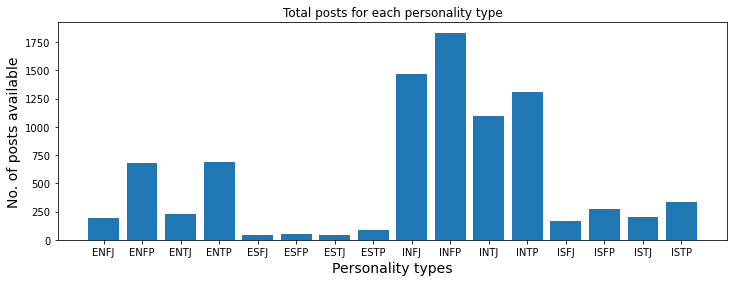

In [49]:
# Data visualization for no. of posts for each personality type
# Group by the data using type
df_total = df.groupby(['type']).count()

plt.figure(figsize = (12,4))
plt.bar(np.array(df_total.index), height = df_total['posts'],)
plt.xlabel('Personality types', size = 14)
plt.ylabel('No. of posts available', size = 14)
plt.title('Total posts for each personality type')

We observe that some of the personality types has a lot more data than others, the most common Kaggle users personality is INFP (Introvert Intuition Feeling Perceiving).
We can consider for now that users who comment on social media more frequently are more intoverted, perceptive, and emotional.

In [50]:
#This function counts the no of words in each post of a user
def var_row(row):
    l = []
    for i in row.split('|||'):
        l.append(len(i.split()))
    return np.var(l)

#this function counts the no of words per post out of the total 50 posts in the whole row
df['words_per_comment'] = df['posts'].apply(lambda x: len(x.split())/50)
df['variance_of_word_counts'] = df['posts'].apply(lambda x: var_row(x))
df.head()

,type,posts,words_per_comment,variance_of_word_counts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,11.12,135.2900
1,ENTP,'I'm finding the lack of me in these posts ver...,23.40,187.4756
2,INTP,'Good one _____ https://www.youtube.com/wat...,16.72,180.6900
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",21.28,181.8324
4,ENTJ,'You're fired.|||That's another silly misconce...,19.34,196.4576


Since the original dataset only came with 2 features, the Type and 50 posts for each person, lets create additional features for exploring & analysing our dataset.Added two more parameter words per comments and Variance of words


/Users/rajibsamanta/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Distribution of Lengths of all 50 Posts')

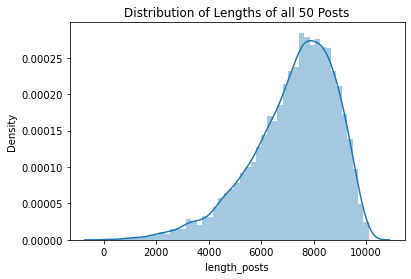

In [51]:
# Add length of the post 
df["length_posts"] = df["posts"].apply(len)
sns.distplot(df["length_posts"]).set_title("Distribution of Lengths of all 50 Posts")

We can see that most no of lengthly posts have between 7000-9000 words

In [52]:
#Finding the most common words in all posts.Top 20
words = list(df["posts"].apply(lambda x: x.split()))
words = [x for y in words for x in y]
Counter(words).most_common(20) 

[('I', 387957),
 ('to', 290168),
 ('the', 270699),
 ('a', 230918),
 ('and', 219498),
 ('of', 177853),
 ('is', 128804),
 ('you', 128750),
 ('that', 127221),
 ('in', 117263),
 ('my', 104561),
 ('it', 93101),
 ('for', 83057),
 ('have', 79784),
 ('with', 77131),
 ('but', 74729),
 ('be', 69317),
 ('are', 65034),
 ('like', 61390),
 ('not', 59496)]

In [53]:

# Convert the list to a DataFrame
df_words = pd.DataFrame(Counter(words).most_common(20) , columns=['Word', 'Count'])
df_words.head()


,Word,Count
0,I,387957
1,to,290168
2,the,270699
3,a,230918
4,and,219498


Text(0.5, 1.0, 'Posts with Common word count')

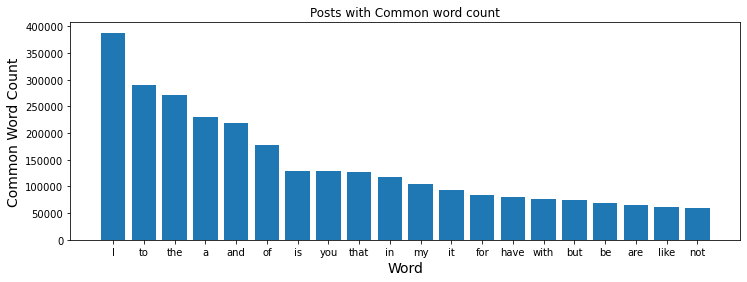

In [54]:
# Barplot for commonly used words.
plt.figure(figsize = (12,4))
plt.bar(df_words['Word'], height = df_words['Count'],)
plt.xlabel('Word', size = 14)
plt.ylabel('Common Word Count', size = 14)
plt.title('Posts with Common word count')

#### Next Steps:
#### Feature Engineering:
    Convert the text data into numerical features that machine learning models can understand. 
#### Label Encoding:
    Encode the categorical MBTI personality types into numerical labels. For example, convert "INFP" to 1,
    "ENFJ" to 2, and so on.
#### Data Splitting:
    Split the dataset into training, validation, and test sets. 
#### Model Selection:
    Choose a machine learning model suitable for text classification tasks. Common choices include logistic regression, support vector machines, random forests, and neural networks
#### Model Training:
    Train the selected model on the training dataset using the prepared text features and the corresponding MBTI labels.